In [691]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [692]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data') # change path here!

# WSTĘP: Klasyfikacja pasażerów Titanica

Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

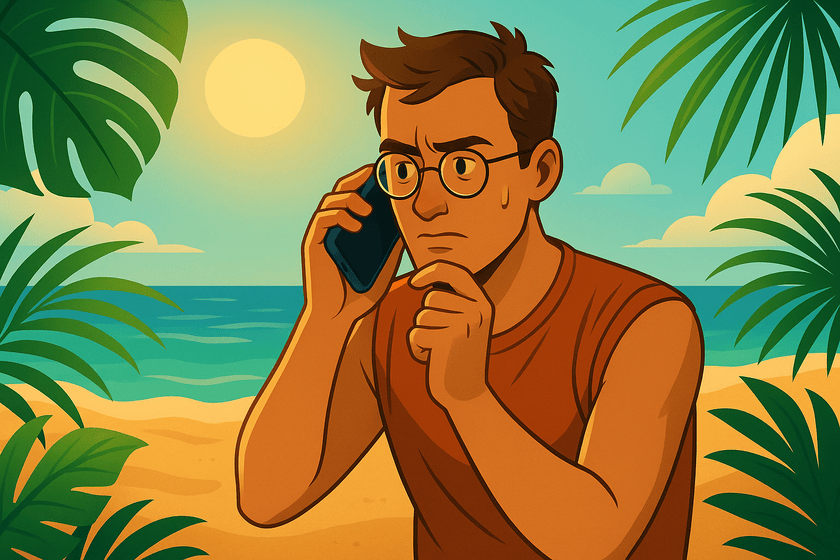

(*AI-generated image*)

**Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).**

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [693]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [694]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

# Obserwacje z zadania pierwszego

Braki danych (malejąco):
* 'Cabin' - zamienione na dodatkową etykietę 'Unknown', ze względu na mnogość NAN
* 'Age' - uzupełnione za pomocą mediany dla każdej klasy 'Pclass' osobno
* 'Fare' - uzupołnione za pomocą mediany dla każdej klasy 'Pclass' osobno
* 'Embarked' - uzupełnione zgodnie z wartością 'Fare' dla tych NAN (w konkretnych portach dominowały wyższe wartości).

Nowe kolumny:
* 'Copassengers' - nieprzydatna, bardziej użyteczna jest kolumna 'IsAlone'
* 'IsAlone' - wykazuje sporą korelację z 'Survived'
* 'KnownCabin' - ogrom NAN w 'Cabin' okazał się 'użyteczny?': więcej śmiertelnych ofiar mamy w przypadku nieprzypisanej kabiny
* 'LifePhase' - wykazała największą przeżywalność dla niemowląt, i to w sumie tyle.

Zależności (z 'Survived'):
* najwięcej przypadków śmiertelnych było w trzeciej klasie, natomiast najwięcej ocalonych w pierwszej klasie
* zdecydowanie więcej przypadków śmiertelnych mamy u mężczyzn (5/6 krotnie! więcej niż u kobiet), natomiast przeżyło ok. 2 razy więcej kobiet niż mężczyzn
* najlepszą przeżywalność mają niemowlaki
* liczba ocalonych samotnych podróżników jest podobna co tych z współpasażerami, natomiast ok. 2 razy więcej przypadków śmiertelnych mamy u samotnych podróżników.

Outliers:
* 'Age' - zostawiłam nieruszone, nie było abstrakcyjnych wartości typu 150/200 lat, wyglądały sensownie + myślę, że wiek jest na tyle istotną daną w kontekście przeżycia aby zostawić go takim jakim jest
* 'Fare' - zamieniłam ogromne outliery (wynoszące ok. 500) na te mniejsze (wynoszące ok 250) ponieważ były bardziej liczne i nie popsuje to normalizacji danych.

# Import potrzebnych bibliotek

In [695]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score



# Import gotowych danych


In [696]:
titanic_EDA = pd.read_csv(base_path / 'titanic_EDA.csv') # z kolumną 'Survived'
titanic_ML = pd.read_csv(base_path / 'titanic_ML.csv') # bez 'Survived' - żeby nie było przecieku danych
titanic_MODEL = titanic_ML.drop(['Deck', 'LifePhase'], axis=1) # wyrzucam 'Deck' bo type=object, a w 'LifePhase' jakimś cudem
# pojawiły się NAN, próbowałam to naprawić ale się poddałam pozdro

# Macierz korelacji

Pozwoliłam sobie zwizualizować macierz korelacji bazującą na zadaniu pierwszym, aby mieć tutaj blisko jak wyglądają zależności między zmienną przewidywaną ('Survived'), a zmiennymi które mamy. Ułatwi to na pewno dobór modelu bardziej niż słowne wnioski.

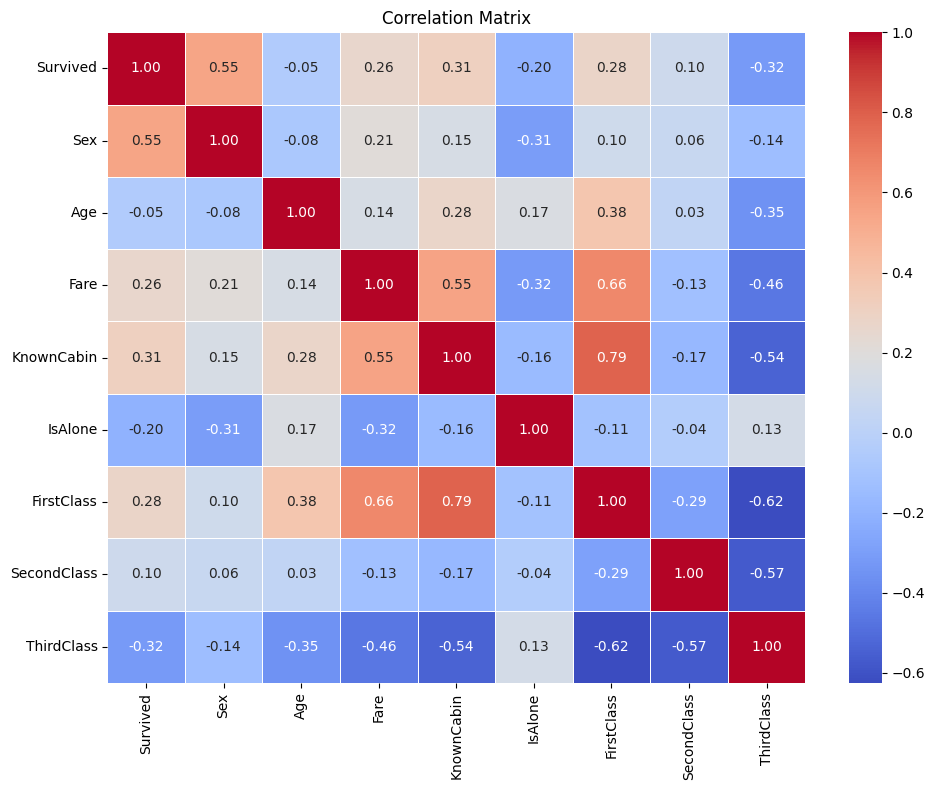

In [697]:
titanic_heatmap = titanic_EDA.drop(columns=['SibSp', 'Parch', 'Pclass', 'LifePhase', 'Embarked'])
corr = titanic_heatmap.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Baseline - Dummy Classifier

Podział danych na traningowe (80%) i testowe (20%):

In [698]:
X = titanic_MODEL.copy()
y = titanic_EDA['Survived'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True, random_state=21)

Sam model i jego skuteczność:

In [699]:
model = DummyClassifier(strategy = 'uniform')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       105
           1       0.38      0.42      0.40        73

    accuracy                           0.48       178
   macro avg       0.47      0.47      0.47       178
weighted avg       0.49      0.48      0.49       178



array([[55, 50],
       [42, 31]])

Interpretacja:
* **precision:** ile z przewidzianych jako "przeżył" ('Survived' = 1) faktycznie przeżyło
* **recall:** ile z tych co przeżyło ('Survived' = 1) zostało poprawnie wykrytych
* **support:** liczba zbadanych przypadków
* **accuracy:** ile przypadków model zgadł

Macież pomyłek:
* Model poprawnie przypisał 51 przypadków =0 do kategorii =0, jednak 54 przypadki =0 przypisał od kategorii =1 (więcej niepoprawnych predykcji niż poprawnych) -> **false positives > true negatives**

* Model poprawnie przypisał 43 przypadki =1 do kategorii =1, jednak 30 przypadków =0 przypisał do kategorii =1 (poszło mu lepiej niż z przypadkami =0, jednak nadal wiele pomyłek) -> **false negatives > true positives**

Podsumowanie:
* Tak naprawdę Dummy Classifier radzi sobie całkowicie losowo - raz zgaduje raz nie. Będzie punktem odniesienia dla moich modeli.

# Model 1 - Drzewo decyzyjne

Podział danych na treningowe (80%) i testowe (20%):

In [700]:
X = titanic_MODEL.copy()
y = titanic_EDA['Survived'].copy()

Po przetestowaniu różnych kombinacji cech, najlepsze wyniki udało mi się uzyskać przy predykcji z 'Pclass', 'IsAlone' oraz 'Sex', co było oczywiste - te zmienne najbardziej korelują z 'Survived'.

In [701]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True, random_state=21)

Predykcja danych testowych:

In [702]:
model = DecisionTreeClassifier(max_depth=3, criterion='gini', random_state=21)
drzewko = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       105
           1       0.93      0.55      0.69        73

    accuracy                           0.80       178
   macro avg       0.84      0.76      0.77       178
weighted avg       0.83      0.80      0.78       178



array([[102,   3],
       [ 33,  40]])

Interpretacja:
* **precision:** ile z przewidzianych jako "przeżył" ('Survived' = 1) faktycznie przeżyło
* **recall:** ile z tych co przeżyło ('Survived' = 1) zostało poprawnie wykrytych
* **support:** liczba zbadanych przypadków
* **accuracy:** ile przypadków model zgadł

Wyniki:
* **accuracy** = 0,80 to całkiem dobry wynik, jednak macież pomyłek pokazuje imbalans w wykrywaniu klas
* **recall:** model bardzo dobrze rozpoznaje dla klasy 0 (=0.97), jednak o wiele gorszy dla klasy 1 (=0.55) - model ma trudności z klasą 1
* **precision**: dla klasy 1 wynosi 0.93 - jak już przewiduje =1 to robi to dokładnie, jednak ma słaby recall

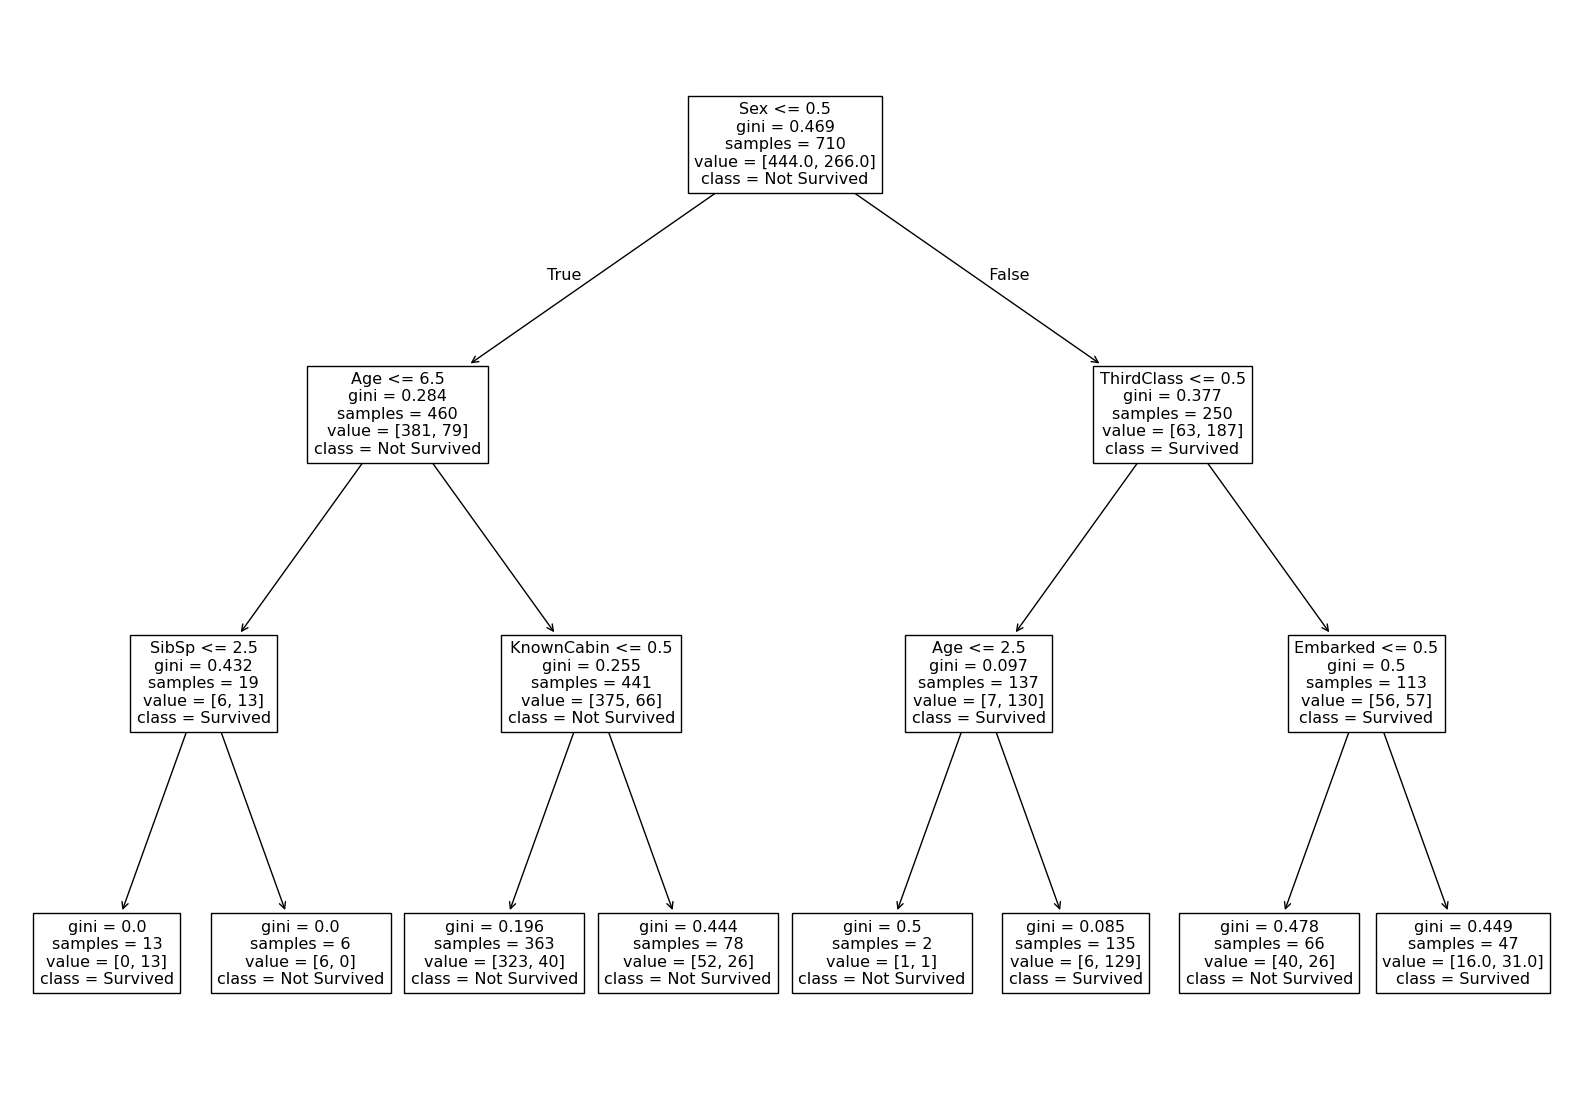

In [703]:
plt.figure(figsize=(20,14))
tree.plot_tree(drzewko, feature_names=titanic_MODEL.columns, class_names=['Not Survived', 'Survived'])
plt.show()

Predykcja danych treningowych:

In [704]:
y_pred_train = model.predict(X_train)
print(classification_report(y_train, y_pred_train))
confusion_matrix(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       444
           1       0.89      0.65      0.75       266

    accuracy                           0.84       710
   macro avg       0.85      0.80      0.82       710
weighted avg       0.84      0.84      0.83       710



array([[422,  22],
       [ 93, 173]])

WNIOSKI:
* wyniki dla danych testowych jak i treningowych za bardzo się nie różnią, co jest dobrym znakiem
* dla obu typów danych mamy spory imbalans pomiędzy klasami -> należy rozwiązać ten problem


## Model 1.1 - Drzewo decyzyjne bez imbalansu klas

Predykcja danych testowych:

In [705]:
model = DecisionTreeClassifier(max_depth=3, criterion='gini', class_weight='balanced', random_state=21)
drzewko = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       105
           1       0.80      0.62      0.70        73

    accuracy                           0.78       178
   macro avg       0.79      0.76      0.76       178
weighted avg       0.78      0.78      0.77       178



array([[94, 11],
       [28, 45]])

Interpretacja:
* **precision:** ile z przewidzianych jako "przeżył" ('Survived' = 1) faktycznie przeżyło
* **recall:** ile z tych co przeżyło ('Survived' = 1) zostało poprawnie wykrytych
* **support:** liczba zbadanych przypadków
* **accuracy:** ile przypadków model zgadł

Wyniki:
* **accuracy**: troszkę słabsza (o 2 pkt procentowe) po zbalansowaniu, jednak nadal dobra (=0.78)
* **recall**: dla klasy 0 się zmniejszył o aż 7 pkt procentowych (=0.90), jest to jednak nadal dobra wartość, dla klasy 1 natomiast się zwiększył (jak oczekiwałam) również o 7 pkt procentowych -> jest lepiej ale nadal nie są to porównywalne wartości (różńica 32 pkt procentowych)
* **precision**: dla klasy 0 o dziwo wzrosła (jedynie o 1 pkt procentowy ALE WZROSŁA), dla klasy 1 natomiast spadła o aż 13 pkt procentowych

Predykcja danych treningowych:

In [706]:
y_pred_train = model.predict(X_train)
print(classification_report(y_train, y_pred_train))
confusion_matrix(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       444
           1       0.78      0.75      0.77       266

    accuracy                           0.83       710
   macro avg       0.82      0.81      0.81       710
weighted avg       0.83      0.83      0.83       710



array([[389,  55],
       [ 67, 199]])

WNIOSKI:

# Model 2 - KNN

Skalowanie (potrzebne aby zachować największą dokładność dla mierzenia odległości):

In [707]:
scaler = StandardScaler()
MODEL_scaled = scaler.fit_transform(titanic_MODEL)

Podział przeskalowanych danych na zbiór treningowy (80%) i testowy (20%):

In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=True, random_state=21)

Predykcja danych testowych:

In [709]:
model = KNeighborsClassifier(n_neighbors=25, metric='manhattan')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       105
           1       0.70      0.60      0.65        73

    accuracy                           0.73       178
   macro avg       0.72      0.71      0.71       178
weighted avg       0.73      0.73      0.73       178



array([[86, 19],
       [29, 44]])

Interpretacja:
* **precision:** ile z przewidzianych jako "przeżył" ('Survived' = 1) faktycznie przeżyło
* **recall:** ile z tych co przeżyło ('Survived' = 1) zostało poprawnie wykrytych
* **support:** liczba zbadanych przypadków
* **accuracy:** ile przypadków model zgadł

Wyniki:
* **accuracy**: widocznie mniejsza (=0.70) niż w drzewie decyzyjnym
* **support**: nadal mamy dysproporcję klas
* **recall**: model w miarę dobrze rozpoznaje klasę 0 (=0.84), jadnak znacznie gorzej radzi sobie z klasą 1 (=0.51)
* **precision**: podobna dla obu klas (ok.=0.7)

Predykcja danych treningowych:

In [710]:
y_pred_train = model.predict(X_train)
print(classification_report(y_train, y_pred_train))
confusion_matrix(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       444
           1       0.69      0.60      0.64       266

    accuracy                           0.75       710
   macro avg       0.73      0.72      0.72       710
weighted avg       0.74      0.75      0.75       710



array([[373,  71],
       [107, 159]])

WNIOSKI:
* między zbiorem testowym a treningowym w accuracy mamy sporą róznicę (train_acc = 0.81, a test_acc = 0.70). Model nauczył się dobrze danych treningowych, ale nie generalizuje wystarczająco dobrze na nowych danych.


# Model 1 - hiperparametry

Hiperparametry które zbadam dla modelu drzewa decyzyjnego to:
* max_depth -> myślę, że jest to kluczowy parametr - można nim przetrenować model
* criterion -> przydziela metodę podziału (np. współczynnik giniego lub entropia)

## max_depth

Funkcja badająca wpływ głębokości drzewa na Accuracy, Precision i Recall:

In [711]:
depths = range(1, 30)
accuracies = []
precisions = []
recalls = []

for d in depths:
  model = DecisionTreeClassifier(max_depth=d, random_state=21)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracies.append(accuracy_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred, average='macro'))
  recalls.append(recall_score(y_test, y_pred, average='macro'))


Wizualizacja wyników:

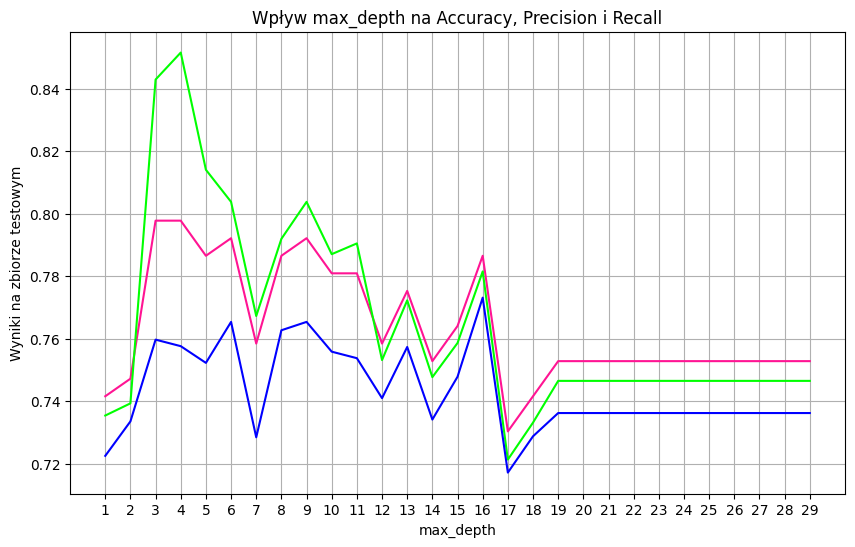

In [712]:
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, color='deeppink')
plt.plot(depths, precisions, color='lime')
plt.plot(depths, recalls, color='blue')
plt.title('Wpływ max_depth na Accuracy, Precision i Recall')
plt.xlabel('max_depth')
plt.ylabel('Wyniki na zbiorze testowym')
plt.xticks(depths)
plt.grid(True)
plt.show()

Wnioski:
* accuracy: rosnie do max_depth = 3 i dla niej (jak i dla = 4) wynosi najwięcej
* precision: rośnie do max_depth = 4 i dla niej wynosi najwięcej
* recall: rośnie do max_depth = 3, potem spada i wynosi więcej dla = 7, a najwięcej dla = 16, jednak przy tej głębokości drzewa pozostałe parametry spadają

Podsumowując:
* myślę, że najlepiej wybrać max_depth = 3 lub = 4 -> z ogółu da nam najlepszą predykcję

## criterion

Funkcja badająca rodzaj kryterium na Accuracy, Precision i Recall:

In [713]:
criteria = ['gini', 'entropy']
accuracies = []
precisions = []
recalls = []

for c in criteria:
  model = DecisionTreeClassifier(criterion = c, random_state = 21)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracies.append(accuracy_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred, average='macro'))
  recalls.append(recall_score(y_test, y_pred, average='macro'))

Wizualizacja wyników:

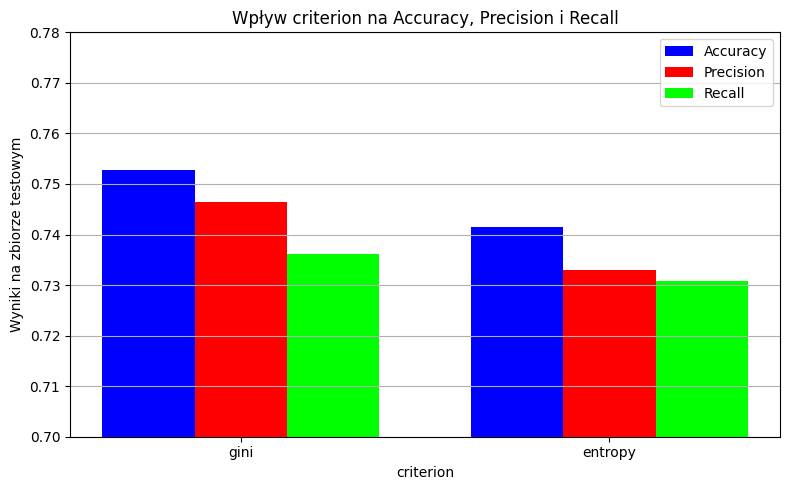

In [714]:
x = np.arange(len(criteria))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, accuracies, width, label='Accuracy', color='blue')
plt.bar(x, precisions, width, label='Precision', color='red')
plt.bar(x + width, recalls, width, label='Recall', color='lime')

plt.title('Wpływ criterion na Accuracy, Precision i Recall')
plt.xlabel('criterion')
plt.ylabel('Wyniki na zbiorze testowym')
plt.xticks(x, criteria)
plt.ylim(0.7, 0.78)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


Wnioski:
* wartości nieznacznie się różnią, ale jednak się różnią
* dla kryterium gini mamy lepsze wartości dla wszystkich parametrów (accuracy, precision, recall)
* dla entropy te wartości są troszkę niższe

# Model 2 - hiperparametry

Hiperparametry które zbadam dla modelu k najbliższych sąsiadów to:
* n_neighbors -> ilość sąsiadów używana do klasyfikacji danych
* metric -> metryka odległości (np. zmiana międy euklidesową a kosinusową)

## n_neighbors

Funkcja badająca wpływ liczby sąsiadów na Accuracy, Precision i Recall:

In [715]:
neighbors_range = range(1, 30)
accuracies = []
precisions = []
recalls = []

for k in neighbors_range:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))

Wizualizacja wyników:

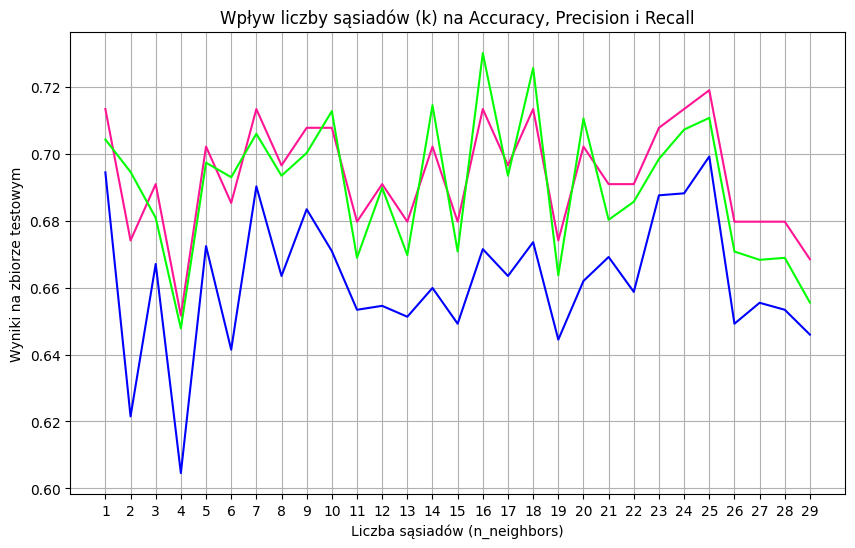

In [716]:
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, color='deeppink')
plt.plot(depths, precisions, color='lime')
plt.plot(depths, recalls, color='blue')
plt.title('Wpływ liczby sąsiadów (k) na Accuracy, Precision i Recall')
plt.xlabel('Liczba sąsiadów (n_neighbors)')
plt.ylabel('Wyniki na zbiorze testowym')
plt.xticks(neighbors_range)
plt.grid(True)
plt.show()

Wnioski:
* dla moich danych najlepszą accuracy model osiąga badając 25 najbliższych sąsiadów (acc = ok. 0.72)
* jeśli chodzi o precision, to najlepszą wartość model osiąga przy 16 sąsiadach
* recall natomiast wynosi najwięcej (tak jak accuracy) dla 25 sąsiadów

Podsumowując:
* myślę, że najlepiej postawić na tych 25 sąsiadów - wartości nadal są okej, a precision wtedy nie odbiega aż tak od recall

## metric

Funkcja badająca rodzaj metryki na Accuracy, Precision i Recall:

In [717]:
metric = ['euclidean', 'manhattan', 'cosine']
accuracies = []
precisions = []
recalls = []

for m in metric:
    model = KNeighborsClassifier(n_neighbors=5, metric=m)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))

Wizualizacja wyników:

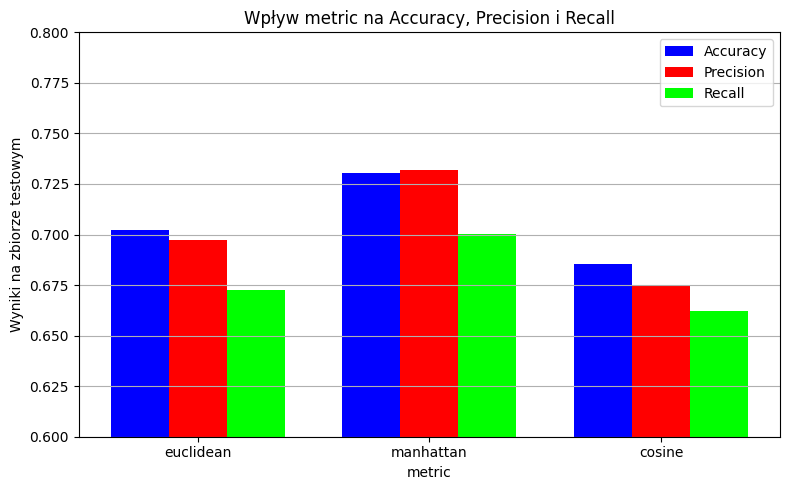

In [718]:
x = np.arange(len(metric))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, accuracies, width, label='Accuracy', color='blue')
plt.bar(x, precisions, width, label='Precision', color='red')
plt.bar(x + width, recalls, width, label='Recall', color='lime')

plt.title('Wpływ metric na Accuracy, Precision i Recall')
plt.xlabel('metric')
plt.ylabel('Wyniki na zbiorze testowym')
plt.xticks(x, distances)
plt.ylim(0.6, 0.8)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

Wnioski:
* wartości nieznacznie się różnią, ale się różnią
* dla metryki odległości 'manhattan' mamy najlepsze wartości accuracy, precision i recall